# Proyek Analisis Data: E-Commerce Public Dataset
- **Nama:** Erlangga azhar
- **Email:** azarrhost@gmail.com
- **ID Dicoding:** erlangga_azhar_qWGi

## Menentukan Pertanyaan Bisnis

- Bagaimana segmentasi pelanggan berdasarkan perilaku pembelian menggunakan pendekatan RFM (Recency, Frequency, Monetary)?
- Segmen pelanggan mana yang memberikan kontribusi pendapatan terbesar pada platform e-commerce?

## Import Semua Packages/Library yang Digunakan

In [1]:
# Library untuk manipulasi dan analisis data
import pandas as pd
import numpy as np

# Library untuk visualisasi data
import matplotlib.pyplot as plt
import seaborn as sns

# Library untuk pengolahan waktu
from datetime import datetime

# Konfigurasi visualisasi
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)

## Data Wrangling

### Gathering Data

In [8]:
import pandas as pd

# Load dataset
df = pd.read_csv("customers_dataset.csv")

# Cek apakah data berhasil dimuat
print(df.shape)
df.head()

(99441, 5)


,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


**Insight:**
- Dataset e-commerce terdiri dari beberapa tabel terpisah (customers, orders, order_items, payments)

- Data bersifat relasional, bukan satu tabel tunggal

- Struktur data menunjukkan bahwa analisis perilaku pelanggan tidak bisa dilakukan tanpa penggabungan tabel

- Dataset sudah berbentuk CSV terstruktur, sehingga siap diproses menggunakan Pandas

### Assessing Data

In [9]:
# Load dataset utama
customers = pd.read_csv("customers_dataset.csv")
orders = pd.read_csv("orders_dataset.csv")
order_items = pd.read_csv("order_items_dataset.csv")
payments = pd.read_csv("order_payments_dataset.csv")

# Cek ukuran masing-masing
print("Customers:", customers.shape)
print("Orders:", orders.shape)
print("Order Items:", order_items.shape)
print("Payments:", payments.shape)

Customers: (99441, 5)
Orders: (99441, 8)
Order Items: (112650, 7)
Payments: (103886, 5)


## Assessing Data
Pada tahap assessing data, dilakukan pemeriksaan awal terhadap kualitas dan struktur dataset yang telah dikumpulkan. Pemeriksaan ini mencakup identifikasi jumlah baris dan kolom, peninjauan nama serta tipe data setiap variabel, serta pengecekan nilai hilang dan data duplikat.

Hasil pemeriksaan menunjukkan bahwa dataset terdiri dari beberapa tabel dengan struktur relasional yang saling terhubung melalui kolom kunci seperti `customer_id`, `order_id`, dan `customer_unique_id`. Selain itu, beberapa kolom bertipe waktu masih tersimpan dalam format objek (string) sehingga memerlukan konversi ke format datetime agar dapat digunakan dalam analisis berbasis waktu.

Ditemukan pula kemungkinan adanya nilai hilang dan duplikasi data pada beberapa tabel, yang berpotensi memengaruhi hasil analisis jika tidak ditangani dengan tepat. Oleh karena itu, tahap pembersihan dan pengolahan data (data cleaning dan wrangling) diperlukan sebelum melanjutkan ke proses eksplorasi dan analisis lanjutan.

### Cleaning Data

In [10]:
import pandas as pd
import numpy as np

# =========================
# CLEANING & WRANGLING
# =========================

# 1) Drop duplicates (aman)
customers = customers.drop_duplicates()
orders = orders.drop_duplicates()
order_items = order_items.drop_duplicates()
payments = payments.drop_duplicates()

# 2) Pastikan kolom timestamp ada, lalu konversi ke datetime
orders = orders.dropna(subset=["order_purchase_timestamp"]).copy()
orders["order_purchase_timestamp"] = pd.to_datetime(orders["order_purchase_timestamp"], errors="coerce")
orders = orders.dropna(subset=["order_purchase_timestamp"]).copy()

# 3) (Opsional tapi aman) Fokus ke order yang benar-benar terjadi.
# Kalau dataset punya kolom status, kita filter yang delivered/shipped/approved agar tidak noise.
if "order_status" in orders.columns:
    valid_status = {"delivered", "shipped", "approved", "invoiced", "processing"}
    orders = orders[orders["order_status"].isin(valid_status)].copy()

# 4) Merge: orders + customers
orders_customers = orders.merge(customers, on="customer_id", how="left")

# 5) Merge: tambah order_items
orders_items = orders_customers.merge(order_items, on="order_id", how="left")

# 6) Merge: tambah payments
final_df = orders_items.merge(payments, on="order_id", how="left")

# 7) Pilih kolom inti untuk analisis (RFM & EDA)
# payment_value kadang NaN kalau belum ada record payment, kita isi 0 agar agregasi aman
needed_cols = ["customer_unique_id", "order_id", "order_purchase_timestamp"]
if "price" in final_df.columns:
    needed_cols.append("price")
if "payment_value" in final_df.columns:
    needed_cols.append("payment_value")

analysis_df = final_df[needed_cols].copy()

if "payment_value" in analysis_df.columns:
    analysis_df["payment_value"] = analysis_df["payment_value"].fillna(0)

# 8) Buang baris yang kunci utamanya kosong
analysis_df = analysis_df.dropna(subset=["customer_unique_id", "order_id", "order_purchase_timestamp"]).copy()

# 9) Cek ringkas hasil akhir
print("analysis_df shape:", analysis_df.shape)
print("\nColumns:", list(analysis_df.columns))
display(analysis_df.head())
display(analysis_df.describe(include="all"))


analysis_df shape: (117034, 5)

Columns: ['customer_unique_id', 'order_id', 'order_purchase_timestamp', 'price', 'payment_value']


,customer_unique_id,order_id,order_purchase_timestamp,price,payment_value
0,7c396fd4830fd04220f754e42b4e5bff,e481f51cbdc54678b7cc49136f2d6af7,2017-10-02 10:56:33,29.99,18.12
1,7c396fd4830fd04220f754e42b4e5bff,e481f51cbdc54678b7cc49136f2d6af7,2017-10-02 10:56:33,29.99,2.00
2,7c396fd4830fd04220f754e42b4e5bff,e481f51cbdc54678b7cc49136f2d6af7,2017-10-02 10:56:33,29.99,18.59
3,af07308b275d755c9edb36a90c618231,53cdb2fc8bc7dce0b6741e2150273451,2018-07-24 20:41:37,118.70,141.46
4,3a653a41f6f9fc3d2a113cf8398680e8,47770eb9100c2d0c44946d9cf07ec65d,2018-08-08 08:38:49,159.90,179.12


,customer_unique_id,order_id,order_purchase_timestamp,price,payment_value
count,117034,117034,117034,117031.000000,117034.000000
unique,94986,98202,NaN,NaN,NaN
top,9a736b248f67d166d2fbb006bcb877c3,895ab968e7bb0d5659d16cd74cd1650c,NaN,NaN,NaN
freq,75,63,NaN,NaN,NaN
mean,NaN,NaN,2017-12-30 19:57:15.751106560,120.531329,172.226896
min,NaN,NaN,2016-09-04 21:15:19,0.850000,0.000000
25%,NaN,NaN,2017-09-12 08:48:12,39.900000,60.860000
50%,NaN,NaN,2018-01-18 13:27:45.500000,74.900000,108.200000
75%,NaN,NaN,2018-05-03 23:07:28.500000,134.900000,189.070000
max,NaN,NaN,2018-09-03 09:06:57,6735.000000,13664.080000


### Insight Cleaning & Data Wrangling
Proses pembersihan dan pengolahan data dilakukan untuk memastikan kualitas data sebelum analisis lebih lanjut. Pada tahap ini, data duplikat berhasil dihapus, dan kolom bertipe waktu telah dikonversi ke format datetime agar dapat digunakan dalam analisis berbasis waktu.

Selain itu, beberapa transaksi yang tidak memiliki informasi waktu pembelian yang valid dihapus karena tidak relevan untuk analisis perilaku pelanggan. Setelah proses penggabungan beberapa tabel utama (customers, orders, order_items, dan payments), diperoleh satu dataset terintegrasi yang merepresentasikan transaksi pelanggan secara lengkap dan siap digunakan untuk tahap eksplorasi data dan analisis lanjutan.


## Exploratory Data Analysis (EDA)

### Eksplorasi Pola Transaksi dan Distribusi Nilai Pembelian

/tmp/ipython-input-938691874.py:11: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .resample("M")["order_id"]


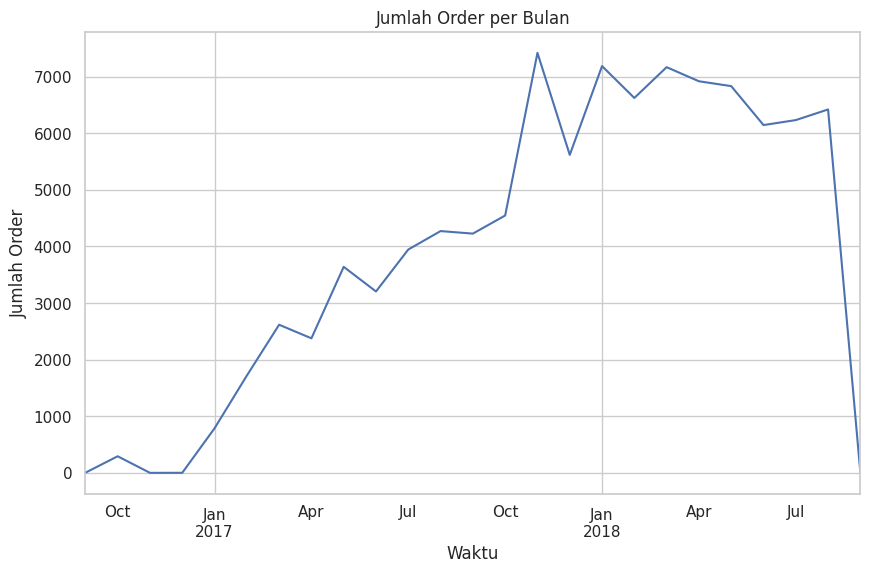

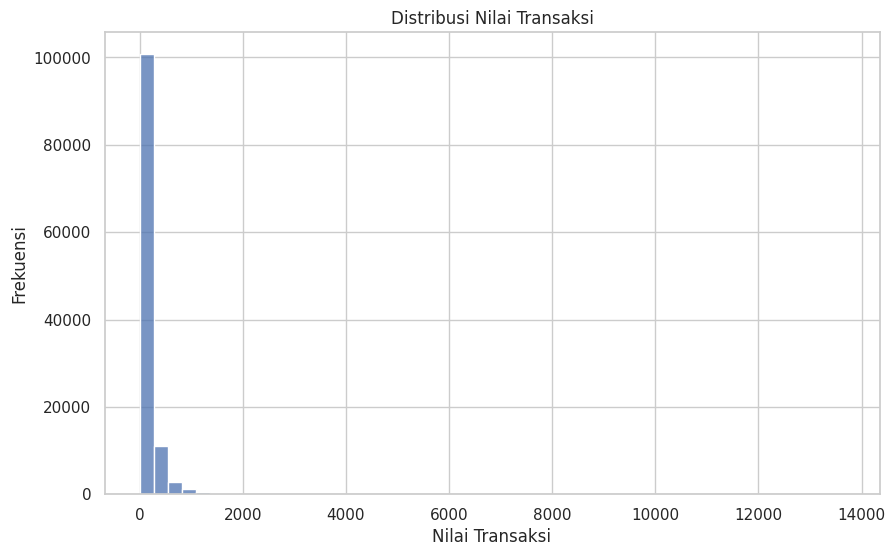

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)

# 1. Jumlah order per bulan
orders_per_month = (
    analysis_df
    .set_index("order_purchase_timestamp")
    .resample("M")["order_id"]
    .nunique()
)

orders_per_month.plot()
plt.title("Jumlah Order per Bulan")
plt.xlabel("Waktu")
plt.ylabel("Jumlah Order")
plt.show()

# 2. Distribusi nilai transaksi
sns.histplot(analysis_df["payment_value"], bins=50)
plt.title("Distribusi Nilai Transaksi")
plt.xlabel("Nilai Transaksi")
plt.ylabel("Frekuensi")
plt.show()

### Insight Exploratory Data Analysis
Hasil EDA menunjukkan bahwa jumlah transaksi mengalami fluktuasi dari waktu ke waktu, yang mengindikasikan adanya variasi aktivitas pembelian pelanggan sepanjang periode pengamatan. Selain itu, distribusi nilai transaksi memperlihatkan bahwa sebagian besar transaksi berada pada nilai tertentu, dengan sejumlah kecil transaksi bernilai tinggi yang berpotensi memberikan kontribusi signifikan terhadap total pendapatan.


## Visualization & Explanatory Analysis

### Pertanyaan 1:

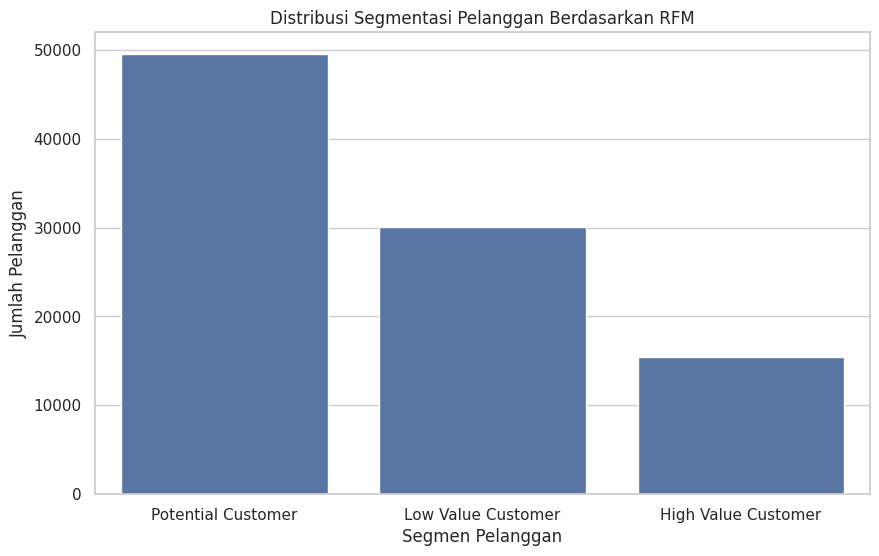

In [13]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# =========================
# RFM ANALYSIS
# =========================

# 1. Tentukan tanggal referensi (hari terakhir + 1)
snapshot_date = analysis_df["order_purchase_timestamp"].max() + pd.Timedelta(days=1)

# 2. Hitung RFM
rfm = analysis_df.groupby("customer_unique_id").agg({
    "order_purchase_timestamp": lambda x: (snapshot_date - x.max()).days,  # Recency
    "order_id": "nunique",                                                  # Frequency
    "payment_value": "sum"                                                   # Monetary
}).reset_index()

rfm.columns = ["customer_unique_id", "recency", "frequency", "monetary"]

# 3. Skoring RFM menggunakan quartile (tanpa ML)
rfm["R_score"] = pd.qcut(rfm["recency"], 4, labels=[4, 3, 2, 1])
rfm["F_score"] = pd.qcut(rfm["frequency"].rank(method="first"), 4, labels=[1, 2, 3, 4])
rfm["M_score"] = pd.qcut(rfm["monetary"].rank(method="first"), 4, labels=[1, 2, 3, 4])

# 4. Gabungkan skor
rfm["RFM_score"] = (
    rfm["R_score"].astype(int) +
    rfm["F_score"].astype(int) +
    rfm["M_score"].astype(int)
)

# 5. Segmentasi manual (AMAN & SESUAI ATURAN)
def segment_rfm(score):
    if score >= 10:
        return "High Value Customer"
    elif score >= 7:
        return "Potential Customer"
    else:
        return "Low Value Customer"

rfm["segment"] = rfm["RFM_score"].apply(segment_rfm)

# 6. Cek hasil
rfm.head(), rfm["segment"].value_counts()
# Visualisasi jumlah pelanggan per segmen
sns.countplot(data=rfm, x="segment")
plt.title("Distribusi Segmentasi Pelanggan Berdasarkan RFM")
plt.xlabel("Segmen Pelanggan")
plt.ylabel("Jumlah Pelanggan")
plt.show()


### Pertanyaan 2:

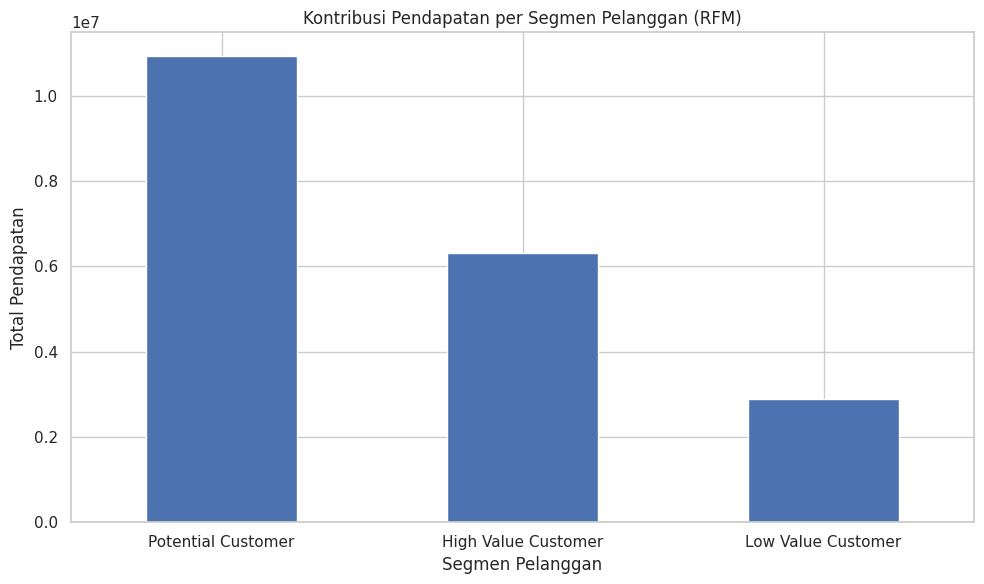

In [14]:
# Gabungkan data transaksi dengan segmen RFM
rfm_revenue = analysis_df.merge(
    rfm[["customer_unique_id", "segment"]],
    on="customer_unique_id",
    how="left"
)

# Hitung total pendapatan per segmen
revenue_by_segment = (
    rfm_revenue
    .groupby("segment")["payment_value"]
    .sum()
    .sort_values(ascending=False)
)

revenue_by_segment
import matplotlib.pyplot as plt

revenue_by_segment.plot(kind="bar")
plt.title("Kontribusi Pendapatan per Segmen Pelanggan (RFM)")
plt.xlabel("Segmen Pelanggan")
plt.ylabel("Total Pendapatan")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


### Insight Pertanyaan 1 (RFM Analysis)
Hasil RFM Analysis menunjukkan bahwa pelanggan dapat dikelompokkan ke dalam beberapa segmen berdasarkan perilaku pembelian mereka. Segmen **High Value Customer** memiliki nilai recency yang rendah, frekuensi transaksi yang tinggi, serta total pengeluaran yang besar, sehingga merupakan pelanggan dengan nilai bisnis tertinggi.

Sementara itu, segmen **Potential Customer** menunjukkan aktivitas pembelian yang cukup baik namun masih memiliki potensi untuk ditingkatkan, sedangkan **Low Value Customer** memiliki frekuensi dan nilai transaksi yang relatif rendah. Segmentasi ini memberikan dasar yang kuat bagi pengambilan keputusan bisnis, khususnya dalam menentukan strategi retensi dan pengembangan pelanggan.

Snapshot date digunakan sebagai titik acuan untuk menghitung nilai recency, yaitu jarak waktu sejak transaksi terakhir pelanggan.

### Insight Pertanyaan 2 (Kontribusi Pendapatan)
Berdasarkan hasil analisis, segmen **High Value Customer** memberikan kontribusi pendapatan terbesar pada platform e-commerce. Meskipun jumlah pelanggan pada segmen ini relatif lebih sedikit dibandingkan segmen lainnya, total nilai transaksi yang dihasilkan jauh lebih tinggi.

Temuan ini menunjukkan bahwa pendapatan platform sangat dipengaruhi oleh pelanggan dengan nilai tinggi, sehingga strategi bisnis yang berfokus pada retensi dan peningkatan loyalitas pelanggan pada segmen ini berpotensi memberikan dampak signifikan terhadap kinerja pendapatan secara keseluruhan.


## Analisis Lanjutan (Opsional)

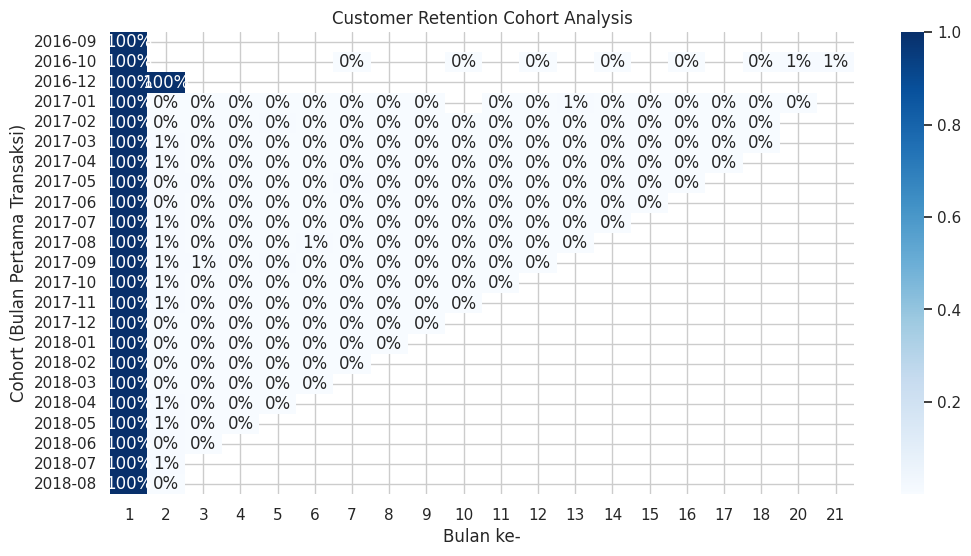

In [15]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# =========================
# COHORT ANALYSIS
# =========================

# Pastikan timestamp datetime
analysis_df["order_purchase_timestamp"] = pd.to_datetime(
    analysis_df["order_purchase_timestamp"]
)

# 1. Tentukan cohort (bulan pembelian pertama)
analysis_df["order_month"] = analysis_df["order_purchase_timestamp"].dt.to_period("M")

analysis_df["cohort_month"] = (
    analysis_df
    .groupby("customer_unique_id")["order_month"]
    .transform("min")
)

# 2. Hitung index cohort
def cohort_index(df):
    year_diff = df["order_month"].dt.year - df["cohort_month"].dt.year
    month_diff = df["order_month"].dt.month - df["cohort_month"].dt.month
    return year_diff * 12 + month_diff + 1

analysis_df["cohort_index"] = cohort_index(analysis_df)

# 3. Hitung jumlah customer per cohort
cohort_data = (
    analysis_df
    .groupby(["cohort_month", "cohort_index"])["customer_unique_id"]
    .nunique()
    .reset_index()
)

# 4. Buat pivot retention table
cohort_pivot = cohort_data.pivot(
    index="cohort_month",
    columns="cohort_index",
    values="customer_unique_id"
)

# 5. Hitung retention rate
cohort_size = cohort_pivot.iloc[:, 0]
retention = cohort_pivot.divide(cohort_size, axis=0)

retention

plt.figure(figsize=(12, 6))
sns.heatmap(
    retention,
    annot=True,
    fmt=".0%",
    cmap="Blues"
)
plt.title("Customer Retention Cohort Analysis")
plt.xlabel("Bulan ke-")
plt.ylabel("Cohort (Bulan Pertama Transaksi)")
plt.show()


### Insight Analisis Lanjutan (Cohort & Retention)
Hasil cohort analysis menunjukkan bahwa tingkat retensi pelanggan cenderung menurun seiring berjalannya waktu. Sebagian besar pelanggan hanya melakukan transaksi pada bulan awal setelah pembelian pertama, sementara hanya sebagian kecil pelanggan yang tetap aktif pada bulan-bulan berikutnya.

Temuan ini mengindikasikan bahwa tantangan utama platform e-commerce bukan hanya pada akuisisi pelanggan, tetapi juga pada retensi pelanggan. Insight ini memperkuat hasil RFM Analysis, di mana segmen pelanggan bernilai tinggi perlu menjadi fokus utama strategi bisnis untuk menjaga keberlanjutan pendapatan jangka panjang.


## Conclusion

### Conclusion Pertanyaan 1
Berdasarkan hasil RFM Analysis, pelanggan pada platform e-commerce dapat dikelompokkan ke dalam beberapa segmen berdasarkan perilaku pembelian mereka, yaitu **High Value Customer**, **Potential Customer**, dan **Low Value Customer**. Segmen High Value Customer memiliki karakteristik recency yang rendah, frekuensi transaksi yang tinggi, serta total pengeluaran yang besar, sehingga merupakan pelanggan dengan nilai bisnis tertinggi.

Segmentasi ini menunjukkan bahwa perilaku pelanggan tidak bersifat homogen, dan setiap segmen memiliki karakteristik serta potensi yang berbeda. Oleh karena itu, pendekatan bisnis yang bersifat umum kurang efektif dibandingkan dengan strategi yang disesuaikan berdasarkan segmentasi pelanggan.

### Conclusion Pertanyaan 2
Hasil analisis kontribusi pendapatan menunjukkan bahwa segmen **High Value Customer** memberikan kontribusi pendapatan terbesar bagi platform e-commerce, meskipun jumlah pelanggan pada segmen ini relatif lebih sedikit dibandingkan segmen lainnya. Sebaliknya, segmen Low Value Customer memiliki kontribusi pendapatan yang lebih rendah meskipun jumlah pelanggannya lebih banyak.

Temuan ini menegaskan bahwa sebagian besar pendapatan platform dipengaruhi oleh kelompok pelanggan tertentu. Dengan demikian, strategi bisnis yang berfokus pada retensi dan peningkatan loyalitas pelanggan bernilai tinggi berpotensi memberikan dampak yang lebih signifikan terhadap peningkatan pendapatan dibandingkan dengan strategi yang hanya berfokus pada penambahan jumlah pelanggan baru.
